In [31]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from bmm import BMM
from lda import LDA
from labellines import labelLine, labelLines

In [2]:
data = sio.loadmat('kos_doc_data.mat')
A = data['A']
B = data['B']
V = data['V']
N = len(V)

# Part (a)

In [3]:
train_words = A[:,1]
train_counts = A[:,2]
train_vocab_counts = np.zeros(N+1) #note word 0 doesn't exist and will always have a zero count
for i in range(N+1):
	if len(np.where(train_words==i)[0]) == 0:
		train_vocab_counts[i] = 0
	else:
		train_vocab_counts[i] = np.sum(train_counts[np.where(train_words==i)[0]])
indexes = np.argsort(train_vocab_counts)[::-1]
top_words = V[indexes[:20]][:,0]
train_probs = train_vocab_counts[indexes[:20]]/np.sum(train_vocab_counts)

Text(0, 0.5, 'Word')

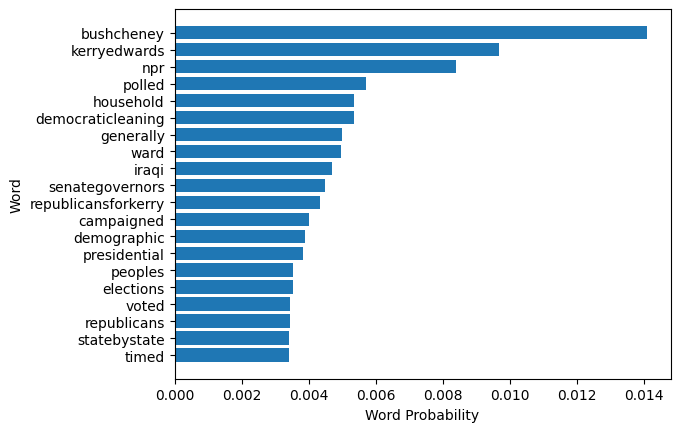

In [4]:
for i in range(len(top_words)):
	top_words[i] = top_words[i][0]
fig, ax = plt.subplots()
ax.barh(range(20), train_probs[::-1], tick_label=top_words[::-1])
ax.set_xlabel('Word Probability')
ax.set_ylabel('Word')

# Part (b)

In [5]:
def get_bayes_probs(counts, alpha):
	bayes_train_counts = counts + np.full(len(V)+1,alpha)
	return bayes_train_counts/np.sum(bayes_train_counts)

Text(0.5, 0, 'Word rarity (common to rare)')

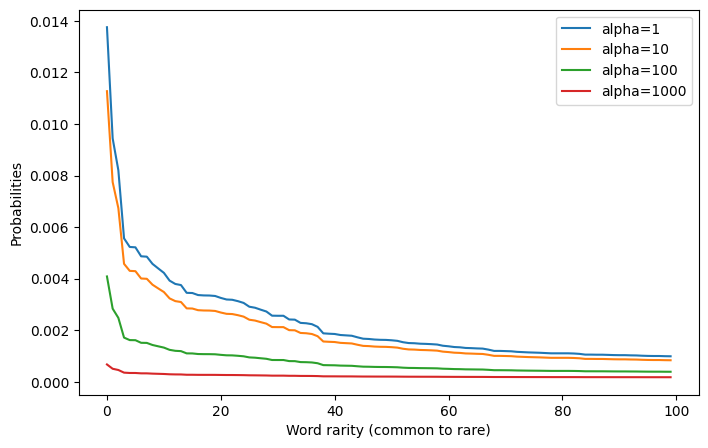

In [6]:
plt.rcParams["figure.figsize"] = (8,5)
alphas = [1, 10, 100, 1000]
bayes_train_probs = np.zeros((N+1, len(alphas)))
fig, ax = plt.subplots()
for i in range(len(alphas)):
	bayes_train_probs = get_bayes_probs(train_vocab_counts, alphas[i])
	indexes = np.argsort(bayes_train_probs)[::-1]
	bayes_train_probs = bayes_train_probs[indexes]
	ax.plot(range(100),  bayes_train_probs[:100], label='alpha='+str(alphas[i]))
ax.legend()
ax.set_ylabel('Probabilities')
ax.set_xlabel('Word rarity (common to rare)')

# Part (c)

In [7]:
def log_prob_cat(train_prob, test_counts):
	out = 0
	for i in range(1,len(test_counts)):
		out += test_counts[i]*np.log(train_prob[i])
	return out

def log_prob_mult(train_prob, test_counts):
	n = np.sum(test_counts)
	out = log_prob_cat(train_prob, test_counts)
	out += n*np.log(n) - n # stirling's approximation
	for i in range(1,len(test_counts)):
		out -= np.log(np.math.factorial(test_counts[i]))
	return out

In [8]:
id = 2001
test_docs = B[:,0]
unique_test_docs = list(set(test_docs))
test_words = B[:,1]
test_counts = B[:,2]
test_words_2001 = B[np.where(test_docs == id)][:,1]
counts_2001 = B[np.where(test_docs == id)][:,2]
test_counts_2001 = np.zeros(N+1)
for i in range(len(test_words_2001)):
	test_counts_2001[test_words_2001[i]] += counts_2001[i]

In [9]:
# log probs for doc 2001
alphas = [1, 10, 100, 1000]
categorical_log_probs_2001 = np.zeros(len(alphas))
multinomial_log_probs_2001 = np.zeros(len(alphas))
for i in range(len(alphas)):
	categorical_log_probs_2001[i] = log_prob_cat(get_bayes_probs(train_vocab_counts, alphas[i]), test_counts_2001)
	multinomial_log_probs_2001[i] = log_prob_mult(get_bayes_probs(train_vocab_counts, alphas[i]), test_counts_2001)
print(categorical_log_probs_2001)
print(multinomial_log_probs_2001)

[-3688.62274798 -3680.75978481 -3744.27109006 -3852.11624446]
[-1692.14160613 -1684.27864296 -1747.78994821 -1855.6351026 ]


C:\Users\tomry\AppData\Local\Temp\ipykernel_8720\4010101434.py:12: DeprecationWarning: Using factorial() with floats is deprecated
  out -= np.log(np.math.factorial(test_counts[i]))


In [10]:
test_vocab_counts = np.zeros(len(V)+1)
for i in range(len(test_words)):
	test_vocab_counts[test_words[i]] += test_counts[i]

In [11]:
def get_perp(train_prob, test_counts, mult=False):
	if mult:
		l = log_prob_mult(train_prob, test_counts)
	else:
		l = log_prob_cat(train_prob, test_counts) 
	return np.exp(-l/np.sum(test_counts))

In [12]:
def get_counts(id):
	test_docs = B[:,0]
	test_words_2001 = B[np.where(test_docs == id)][:,1]
	counts_2001 = B[np.where(test_docs == id)][:,2]
	test_counts_2001 = np.zeros(N+1)
	for i in range(len(test_words_2001)):
		test_counts_2001[test_words_2001[i]] += counts_2001[i]
	return test_counts_2001

Text(0, 0.5, 'Perplexity')

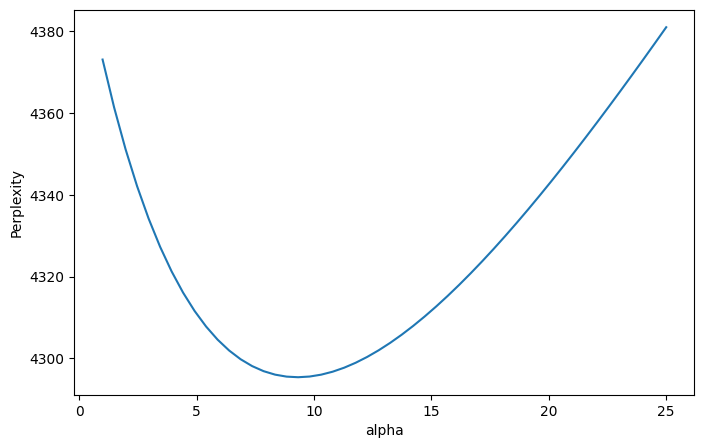

In [43]:
alpha_linspace = np.linspace(1, 25, num=50)
y1 = []
y2 = []
fig, ax = plt.subplots()
for a in alpha_linspace:
	y1.append(get_perp(get_bayes_probs(train_vocab_counts, a), test_counts_2001, mult=False))
	y2.append(get_perp(get_bayes_probs(train_vocab_counts, a), test_vocab_counts, mult=False))
ax.plot(alpha_linspace, y1)
ax.set_xlabel('alpha')
ax.set_ylabel("Perplexity")

2679.0107554254946


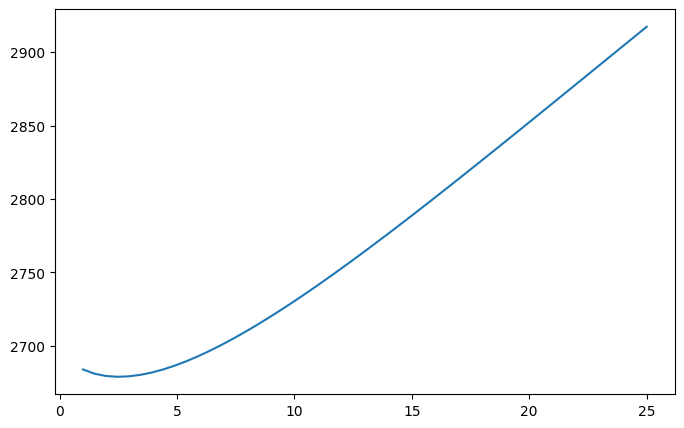

In [42]:
fig, ax = plt.subplots()
ax.plot(alpha_linspace, y2)
ax.set_xlabel("alpha")
ax.set_ylabel("Perplexity")

# Part (d)

In [23]:
np.random.seed(100)

In [40]:
perp, swk, sd_iters = BMM(A, B, 20, 1, 1)

In [41]:
print(perp)

2044.0236428639575


In [25]:
counts = np.zeros((50, 20))
for i in range(50): # iterations
	for t in sd_iters[i]: #topics
		counts[i][int(t)] += 1

C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line1), but could not find a label for it.
  warnings.warn(
C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(
C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line3), but could not find a label for it.
  warnings.warn(
C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
C:\Users\tomry\AppData\Roaming\Python\Python39\site-packages\labelline

[]

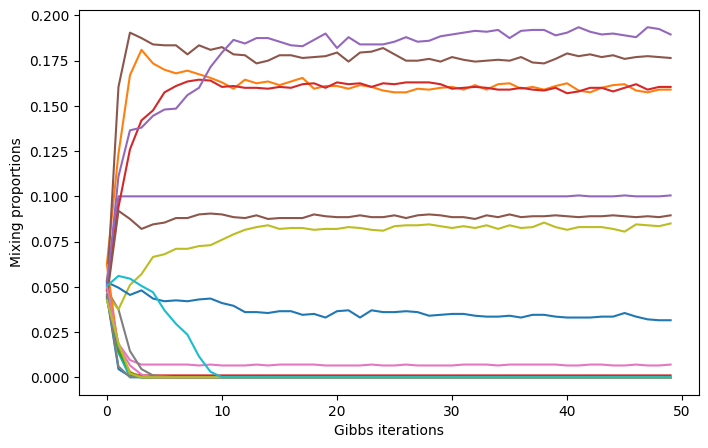

In [34]:
fig, ax = plt.subplots()
ax.plot(counts/np.sum(counts[0]))
ax.set_xlabel("Gibbs iterations")
ax.set_ylabel("Mixing proportions")

# Part (e)

In [28]:
sk_iters, perp, entropy = LDA(A, B, 20, 1, 1)

7.3094432477973506
7.330904658372491
7.389797296314558
7.345486302695721
7.403906552406789
7.375747912112065
7.340868515295536
7.391701954167411
7.337155131657122
7.352147414208489
7.402380712410686
7.397723642959554
7.411879550208381
7.309428951066724
7.364752179386462
7.3509091301331235
7.29743271812366
7.34543201333234
7.403772377428808
7.381999495228618


[Text(2.555, 0.05224135521408764, '1'),
 Text(4.865, 0.039079434199589556, '2'),
 Text(7.175, 0.043573049452368166, '3'),
 Text(9.485, 0.028950617510978383, '4'),
 Text(11.795000000000002, 0.030697651325129274, '5'),
 Text(14.105, 0.06634169798968731, '6'),
 Text(16.415000000000003, 0.02250364107128408, '7'),
 Text(18.725, 0.026498815732370225, '8'),
 Text(21.035, 0.03209087599026106, '9'),
 Text(23.345000000000002, 0.0688996425130012, '10'),
 Text(25.655, 0.0550993019441114, '11'),
 Text(27.965, 0.06389833687632863, '12'),
 Text(30.275000000000002, 0.07276644182745, '13'),
 Text(32.585, 0.09127976299936005, '14'),
 Text(34.894999999999996, 0.09008367108253831, '15'),
 Text(37.205, 0.011367976226379011, '16'),
 Text(39.515, 0.13794643579577637, '17'),
 Text(41.824999999999996, 0.015192829664065202, '18'),
 Text(44.135, 0.06966551795158478, '19'),
 Text(46.445, 0.11008554678592708, '20')]

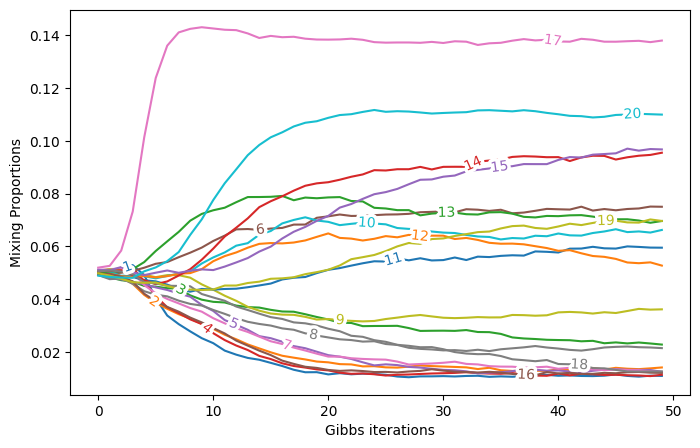

In [33]:
fig, ax = plt.subplots()
plot = sk_iters/np.sum(sk_iters[0,:])
for i in range(len(plot[0])):
	ax.plot(plot[:,i], label=str(i+1))
ax.set_xlabel("Gibbs iterations")
ax.set_ylabel("Mixing Proportions")
labelLines(ax.get_lines(), zorder=2.5)

In [38]:
print(perp)

[1914.74301711]


[Text(2.555, 7.08281262373308, '1'),
 Text(4.865, 7.369999437530457, '2'),
 Text(7.175, 7.331644332768852, '3'),
 Text(9.485, 7.1546355995678805, '4'),
 Text(11.795000000000002, 7.245129425711625, '5'),
 Text(14.105, 7.004658567751604, '6'),
 Text(16.415000000000003, 7.355813753216445, '7'),
 Text(18.725, 7.344670612237484, '8'),
 Text(21.035, 6.894923436489474, '9'),
 Text(23.345000000000002, 6.885770850514806, '10'),
 Text(25.655, 6.466254175809435, '11'),
 Text(27.965, 7.00276402938904, '12'),
 Text(30.275000000000002, 6.4005382844270216, '13'),
 Text(32.585, 6.683779561554243, '14'),
 Text(34.894999999999996, 6.307597596677991, '15'),
 Text(37.205, 7.325144614500743, '16'),
 Text(39.515, 5.768071715530329, '17'),
 Text(41.824999999999996, 7.268777679539431, '18'),
 Text(44.135, 7.106444837970002, '19'),
 Text(46.445, 7.0414370589687145, '20')]

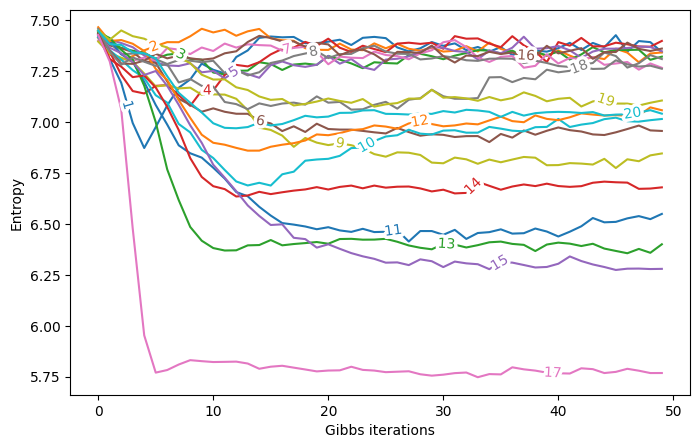

In [36]:
fig, ax = plt.subplots()
for i in range(len(entropy[0])):
	ax.plot(entropy[:,i], label=str(i+1))
ax.set_xlabel("Gibbs iterations")
ax.set_ylabel("Entropy")
labelLines(ax.get_lines(), zorder=2.5)